<a href="https://colab.research.google.com/github/Lotaristo/Lotaristo/blob/main/ParkinsonDiseaseDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Создание модели определения болезни Паркинсона через использовать XGBoost.

### Загрузка данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [ ]:
df = pd.read_csv('/content/parkinsons.data')
print(df.shape)
df.head()

(195, 24)


,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [ ]:
df.status.value_counts()

status
1    147
0     48
Name: count, dtype: int64

Как мы видим, есть дисбаланс классов, что может исказить результаты (особенно учитывая малое количество данных). Чтобы решить данную проблему мы будем брать случайные записи меньшего класса, доведя их количество до числа записей большего класса.


In [ ]:
class_1_samples = df[df.status == 0].sample(n=len(df[df.status == 1]) - len(df[df.status == 0]), replace=True, random_state=73)
df2 = df.copy()
df2 = pd.concat([df, class_1_samples])
df2.status.value_counts()

status
1    147
0    147
Name: count, dtype: int64

### Создание модели 1
Проверим 2 модели - одна без балансировки классов, вторая с ней.

In [ ]:
x = df.drop(df[['status', 'name']], axis = 1)
y = df.status

Нормализация данных используя StandardScaler.

In [ ]:
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)
x_normalized[0]

array([-0.82929965, -0.43616456, -0.95203729,  0.33491386,  0.74975946,
        0.13296255,  0.76080023,  0.13175532,  0.74598495,  0.73953578,
        0.60785907,  1.11914677,  0.33298451,  0.60753214, -0.06789281,
       -0.19322537, -0.8078385 ,  1.76081412,  0.80132308,  0.48047686,
       -0.21053082,  0.86888575])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_normalized, y, test_size = 0.2, random_state = 73)

Создание модели через XGBClassifier.

In [ ]:
model = xgb.XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
print('Результаты первой модели')
print(classification_report(y_test, y_pred))

Результаты первой модели
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.97      1.00      0.98        29

    accuracy                           0.97        39
   macro avg       0.98      0.95      0.97        39
weighted avg       0.98      0.97      0.97        39



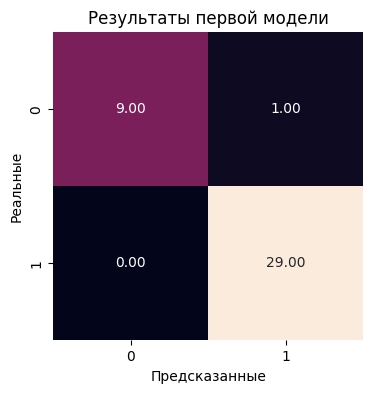

In [ ]:
plt.figure(figsize = (4, 4))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt=".2f", cbar=False)
plt.title("Результаты первой модели")
plt.xlabel("Предсказанные")
plt.ylabel("Реальные");

### Создание модели 2

In [ ]:
x = df2.drop(df2[['status', 'name']], axis = 1)
y = df2.status

Нормализация данных используя StandardScaler.

In [ ]:
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)
x_normalized[0]

array([-0.92222945, -0.52651925, -1.02079644,  0.59926731,  1.08141946,
        0.35897712,  1.08601877,  0.35759403,  1.09396651,  1.08191558,
        0.92953816,  1.51269854,  0.6272576 ,  0.92918006,  0.06508477,
       -0.43907469, -0.64666191,  1.94654386,  1.13295929,  0.76542786,
        0.02125912,  1.21650415])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_normalized, y, test_size = 0.2, random_state = 73)

Создание модели через XGBClassifier.

In [ ]:
model = xgb.XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
print('\nРезультаты второй модели')
print(classification_report(y_test, y2_pred))


Результаты второй модели
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        31
           1       1.00      0.96      0.98        28

    accuracy                           0.98        59
   macro avg       0.98      0.98      0.98        59
weighted avg       0.98      0.98      0.98        59



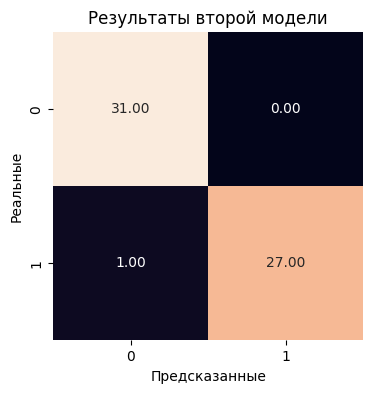

In [ ]:
plt.figure(figsize = (4, 4))
conf_matrix2 = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix2, annot = True, fmt=".2f", cbar=False)
plt.title("Результаты второй модели")
plt.xlabel("Предсказанные")
plt.ylabel("Реальные");

Как мы видим, на второй модели ситуация несколько улучшилась за счет появления большего количества данных.
Однако надо помнить, что несмотря на то, что модель дает довольно высокую оценку, записей было довольно мало, а потому необходима более тщательная проверка при большем количестве данных.